In [1]:
# model.py
import torch, torchvision
from torch import nn

def conv3x3(i, o): return nn.Conv2d(i, o, 3, padding=1)

class ConvRelu(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.block = nn.Sequential(conv3x3(i, o), nn.ReLU(inplace=True))
    def forward(self, x): return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, i, m, o):
        super().__init__()
        self.block = nn.Sequential(
            ConvRelu(i, m),
            nn.ConvTranspose2d(m, o, 3, 2, 1, 1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

class UNet11_4ch(nn.Module):
    """UNet-11，首層改為 4→64，RGB 權重沿用並為第 4 通道初始化均值"""
    def __init__(self, num_filters=32, pretrained=True):
        super().__init__()
        enc = torchvision.models.vgg11(pretrained=pretrained).features
        old = enc[0]                                   # 3→64
        new = nn.Conv2d(4, 64, 3, padding=1)           # ★★ 改 4→64
        if pretrained:
            with torch.no_grad():
                new.weight[:, :3] = old.weight         # RGB 權重複製
                new.weight[:, 3:4] = old.weight.mean(1, keepdim=True)
                new.bias = old.bias
        enc[0] = new
        self.encoder = enc

        self.relu, self.pool = nn.ReLU(inplace=True), nn.MaxPool2d(2,2)
        self.conv1, self.conv2 = enc[0], enc[3]
        self.conv3s, self.conv3 = enc[6], enc[8]
        self.conv4s, self.conv4 = enc[11], enc[13]
        self.conv5s, self.conv5 = enc[16], enc[18]

        nf = num_filters
        self.center = DecoderBlock(nf*8*2, nf*8*2, nf*8)
        self.dec5   = DecoderBlock(nf*(16+8), nf*8*2, nf*8)
        self.dec4   = DecoderBlock(nf*(16+8), nf*8*2, nf*4)
        self.dec3   = DecoderBlock(nf*(8+4),  nf*4*2, nf*2)
        self.dec2   = DecoderBlock(nf*(4+2),  nf*2*2, nf)
        self.dec1   = ConvRelu(nf*(2+1), nf)
        self.final  = nn.Conv2d(nf, 1, 1)

    def forward(self, x):
        c1 = self.relu(self.conv1(x))
        c2 = self.relu(self.conv2(self.pool(c1)))
        c3s= self.relu(self.conv3s(self.pool(c2)))
        c3 = self.relu(self.conv3(c3s))
        c4s= self.relu(self.conv4s(self.pool(c3)))
        c4 = self.relu(self.conv4(c4s))
        c5s= self.relu(self.conv5s(self.pool(c4)))
        c5 = self.relu(self.conv5(c5s))

        ctr = self.center(self.pool(c5))
        d5  = self.dec5(torch.cat([ctr, c5], 1))
        d4  = self.dec4(torch.cat([d5,  c4], 1))
        d3  = self.dec3(torch.cat([d4,  c3], 1))
        d2  = self.dec2(torch.cat([d3,  c2], 1))
        d1  = self.dec1(torch.cat([d2,  c1], 1))
        return self.final(d1)


In [5]:
# train_unet4ch.py
import os, csv, random, argparse
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import torch, torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
#from model import UNet11_4ch                 # ★★ 改成 4ch 版本

# ---------------- Dataset ----------------
class AerialPatchDataset4C(Dataset):
    """
    root/
     ├─ images/        austin1.tif ...
     ├─ depth_images/  austin1_depth.png / tif / jpg ...
     └─ gt/            austin1.tif (遮罩，與 images 同名)
    """
    COMMON_EXTS = [".png", ".jpg", ".jpeg", ".tif", ".tiff"]

    def __init__(self, root, crop=256):
        self.crop      = crop
        self.img_dir   = os.path.join(root, "images")
        self.depth_dir = os.path.join(root, "depth_images")
        self.mask_dir  = os.path.join(root, "gt")

        self.names     = sorted(os.listdir(self.img_dir))           # ex: austin1.tif
        self.depth_map = self._build_depth_map()                    # ★★ 建對應表

        self.mean = torch.tensor([0.485,0.456,0.406,0.5]).view(4,1,1)
        self.std  = torch.tensor([0.229,0.224,0.225,0.5]).view(4,1,1)

    # ----------  新增：掃描 depth_images ----------
    def _build_depth_map(self):
        depth_files = os.listdir(self.depth_dir)
        depth_dict  = {}
        for f in depth_files:
            stem, ext = os.path.splitext(f)
            if stem.endswith("_depth"):
                base = stem[:-6]                    # 去掉 "_depth"
                depth_dict[base] = f
        return depth_dict                           # {austin1: austin1_depth.png}

    def __len__(self): return len(self.names)

    def _random_crop(self, img, depth, msk):
        h, w = img.shape[:2]; ch = cw = self.crop
        top  = random.randint(0, h - ch); left = random.randint(0, w - cw)
        return (arr[top:top+ch, left:left+cw] for arr in (img, depth, msk))

    def __getitem__(self, idx):
        name = self.names[idx]                      # austin1.tif
        stem, ext = os.path.splitext(name)          # austin1, .tif
        try:
            # --- 找對應的深度圖檔名 ---
            if stem in self.depth_map:
                depth_fname = self.depth_map[stem]
            else:
                # 保險：按副檔名猜測
                depth_fname = None
                for ex in [ext] + self.COMMON_EXTS:
                    cand = f"{stem}_depth{ex}"
                    if os.path.exists(os.path.join(self.depth_dir, cand)):
                        depth_fname = cand; break
                if depth_fname is None:
                    raise FileNotFoundError(f"找不到 {stem}_depth.*")

            # --- 讀檔 ---
            rgb   = Image.open(os.path.join(self.img_dir,   name)).convert("RGB")
            depth = Image.open(os.path.join(self.depth_dir, depth_fname)).convert("L")
            msk   = Image.open(os.path.join(self.mask_dir,  name)).convert("L")

            rgb   = np.asarray(rgb)
            depth = np.asarray(depth)[..., None]              # H×W×1
            msk   = (np.asarray(msk) // 255).astype(np.uint8)

            rgb, depth, msk = self._random_crop(rgb, depth, msk)

            # --- to tensor ---
            rgb   = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0
            depth = torch.from_numpy(depth).permute(2,0,1).float() / 255.0
            img4  = torch.cat([rgb, depth], 0)                # 4×H×W
            img4  = (img4 - self.mean) / self.std
            msk   = torch.from_numpy(msk).float().unsqueeze(0)
            return img4, msk

        except Exception as e:
            print(f"❌ [錯誤] {name}: {e}")
            return (torch.zeros(4, self.crop, self.crop),
                    torch.zeros(1, self.crop, self.crop))

# ---------------- Metric -----------------
def dice_coef(pred, target, eps=1e-7):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum((1,2,3))
    union = pred.sum((1,2,3)) + target.sum((1,2,3))
    return ((2*inter+eps)/(union+eps)).mean()

# ---------------- Train ------------------
def main(args):
    torch.multiprocessing.set_start_method('spawn', force=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("🚀 Device:", device)

    root = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\train"
    if not os.path.exists(root):
        print(f"❌ 找不到資料目錄 {root}"); return

    data = AerialPatchDataset4C(root, crop=args.crop)
    print(f"📊 共 {len(data)} 張影像")
    v = int(0.1*len(data))
    train_ds, val_ds = torch.utils.data.random_split(data, [len(data)-v, v])

    def loader(ds, shf): return DataLoader(
        ds, batch_size=args.bs, shuffle=shf,
        num_workers=0, pin_memory=False, persistent_workers=False)

    train_ld, val_ld = loader(train_ds, True), loader(val_ds, False)

    model = UNet11_4ch(pretrained=True).to(device)      # ★★
    crit  = nn.BCEWithLogitsLoss()
    opt   = torch.optim.Adam(model.parameters(), lr=args.lr)
    scaler= torch.amp.GradScaler(device.type)

    best = 0; os.makedirs("checkpoints", exist_ok=True)
    with open("metrics.csv","w",newline="") as f:
        csv.writer(f).writerow(["epoch","train_loss","val_loss","dice"])

    for ep in range(1, args.epochs+1):
        # ---- train ----
        model.train(); tr_loss=0; n_tr=0
        for img,msk in tqdm(train_ld, desc=f"Ep{ep}/{args.epochs} train"):
            img,msk = img.to(device), msk.to(device)
            with torch.amp.autocast(device.type):
                pred = model(img); loss = crit(pred, msk)
            opt.zero_grad(); scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            tr_loss += loss.item(); n_tr += 1

        # ---- val ----
        model.eval(); vl_loss=0; dices=[]; n_v=0
        with torch.no_grad():
            for img,msk in tqdm(val_ld, desc=f"Ep{ep}/{args.epochs} val"):
                img,msk = img.to(device), msk.to(device)
                with torch.amp.autocast(device.type):
                    pred = model(img); loss = crit(pred, msk)
                vl_loss += loss.item(); dices.append(dice_coef(pred, msk).item()); n_v += 1

        tr_loss /= max(n_tr,1); vl_loss /= max(n_v,1); dice = np.mean(dices) if dices else 0
        print(f"📝 Ep{ep} train={tr_loss:.4f} val={vl_loss:.4f} dice={dice:.4f}")
        with open("metrics.csv","a",newline="") as f:
            csv.writer(f).writerow([ep,tr_loss,vl_loss,dice])

        if dice > best:
            best = dice
            torch.save(model.state_dict(), "checkpoints/best_unet4ch.pth")
            print(f"  👑  Saved best model (dice {best:.4f})")

# ---------------- Run --------------------
if __name__ == "__main__":
    args = argparse.Namespace(epochs=100, bs=4, lr=1e-4, crop=256)
    main(args)


🚀 Device: cuda
📊 共 180 張影像


Ep1/100 train:   0%|          | 0/41 [00:00<?, ?it/s]C:\Users\op237\AppData\Local\Temp\ipykernel_28692\4286199000.py:80: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  rgb   = torch.from_numpy(rgb).permute(2,0,1).float() / 255.0
Ep1/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


📝 Ep1 train=0.4090 val=0.3375 dice=0.1500
  👑  Saved best model (dice 0.1500)


Ep2/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


📝 Ep2 train=0.3788 val=0.2855 dice=0.4291
  👑  Saved best model (dice 0.4291)


Ep3/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


📝 Ep3 train=0.3226 val=0.2493 dice=0.3237


Ep4/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


📝 Ep4 train=0.2609 val=0.2925 dice=0.4800
  👑  Saved best model (dice 0.4800)


Ep5/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


📝 Ep5 train=0.3089 val=0.2090 dice=0.5599
  👑  Saved best model (dice 0.5599)


Ep6/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


📝 Ep6 train=0.2616 val=0.2509 dice=0.5211


Ep7/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep7 train=0.2403 val=0.2002 dice=0.8017
  👑  Saved best model (dice 0.8017)


Ep8/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


📝 Ep8 train=0.2368 val=0.1573 dice=0.7120


Ep9/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


📝 Ep9 train=0.2449 val=0.2174 dice=0.7604


Ep10/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


📝 Ep10 train=0.2244 val=0.2235 dice=0.7221


Ep11/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep11 train=0.2316 val=0.3150 dice=0.6317


Ep12/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


📝 Ep12 train=0.2324 val=0.1361 dice=0.7840


Ep13/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep13 train=0.2191 val=0.1458 dice=0.6940


Ep14/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


📝 Ep14 train=0.2091 val=0.1030 dice=0.8957
  👑  Saved best model (dice 0.8957)


Ep15/100 val: 100%|██████████| 5/5 [00:25<00:00,  5.03s/it]


📝 Ep15 train=0.1782 val=0.1355 dice=0.8129


Ep16/100 val: 100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


📝 Ep16 train=0.2066 val=0.1318 dice=0.6843


Ep17/100 val: 100%|██████████| 5/5 [00:25<00:00,  5.08s/it]


📝 Ep17 train=0.2192 val=0.1961 dice=0.7633


Ep18/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.33s/it]


📝 Ep18 train=0.2064 val=0.0943 dice=0.7199


Ep19/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


📝 Ep19 train=0.2155 val=0.1130 dice=0.6950


Ep20/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep20 train=0.1783 val=0.1422 dice=0.7714


Ep21/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


📝 Ep21 train=0.2013 val=0.1164 dice=0.8825


Ep22/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


📝 Ep22 train=0.1964 val=0.1300 dice=0.8151


Ep23/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.26s/it]


📝 Ep23 train=0.1767 val=0.1581 dice=0.7112


Ep24/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep24 train=0.1916 val=0.1413 dice=0.7978


Ep25/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep25 train=0.2058 val=0.2295 dice=0.7915


Ep26/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


📝 Ep26 train=0.1966 val=0.1061 dice=0.7633


Ep27/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


📝 Ep27 train=0.1578 val=0.1587 dice=0.7185


Ep28/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


📝 Ep28 train=0.1797 val=0.1617 dice=0.7232


Ep29/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep29 train=0.1909 val=0.1647 dice=0.7005


Ep30/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.24s/it]


📝 Ep30 train=0.1660 val=0.1194 dice=0.8005


Ep31/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.23s/it]


📝 Ep31 train=0.1492 val=0.1819 dice=0.7849


Ep32/100 val: 100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


📝 Ep32 train=0.1563 val=0.1347 dice=0.7158


Ep33/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep33 train=0.1560 val=0.0980 dice=0.8329


Ep34/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep34 train=0.1628 val=0.1332 dice=0.7512


Ep35/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep35 train=0.1679 val=0.1659 dice=0.6883


Ep36/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep36 train=0.1883 val=0.1686 dice=0.8717


Ep37/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep37 train=0.1642 val=0.1464 dice=0.8344


Ep38/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep38 train=0.1556 val=0.1188 dice=0.7780


Ep39/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep39 train=0.1904 val=0.1242 dice=0.7940


Ep40/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep40 train=0.1438 val=0.1434 dice=0.6290


Ep41/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


📝 Ep41 train=0.1533 val=0.1205 dice=0.8335


Ep42/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep42 train=0.2339 val=0.0730 dice=0.6548


Ep43/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep43 train=0.1783 val=0.1518 dice=0.6695


Ep44/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep44 train=0.1480 val=0.0921 dice=0.8387


Ep45/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep45 train=0.1423 val=0.2400 dice=0.8193


Ep46/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep46 train=0.1653 val=0.1177 dice=0.8314


Ep47/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep47 train=0.1856 val=0.1263 dice=0.9078
  👑  Saved best model (dice 0.9078)


Ep48/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep48 train=0.1599 val=0.1129 dice=0.8613


Ep49/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep49 train=0.2005 val=0.1302 dice=0.7359


Ep50/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep50 train=0.1686 val=0.1444 dice=0.8162


Ep51/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep51 train=0.1616 val=0.1521 dice=0.8427


Ep52/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


📝 Ep52 train=0.1641 val=0.1590 dice=0.7491


Ep53/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep53 train=0.1622 val=0.1249 dice=0.8206


Ep54/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep54 train=0.1575 val=0.1322 dice=0.8249


Ep55/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep55 train=0.1388 val=0.1228 dice=0.8117


Ep56/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep56 train=0.1369 val=0.2532 dice=0.7641


Ep57/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep57 train=0.1495 val=0.1728 dice=0.7480


Ep58/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep58 train=0.1518 val=0.1166 dice=0.7962


Ep59/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep59 train=0.1657 val=0.1787 dice=0.7360


Ep60/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep60 train=0.1517 val=0.1277 dice=0.8293


Ep61/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep61 train=0.1461 val=0.3179 dice=0.6792


Ep62/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep62 train=0.1572 val=0.0819 dice=0.8063


Ep63/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep63 train=0.1778 val=0.0948 dice=0.8230


Ep64/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep64 train=0.1524 val=0.1734 dice=0.7451


Ep65/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


📝 Ep65 train=0.1556 val=0.1125 dice=0.9043


Ep66/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep66 train=0.1413 val=0.1324 dice=0.8678


Ep67/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep67 train=0.1573 val=0.1252 dice=0.8541


Ep68/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep68 train=0.1408 val=0.0829 dice=0.7480


Ep69/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


📝 Ep69 train=0.1378 val=0.1517 dice=0.7398


Ep70/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep70 train=0.1464 val=0.1159 dice=0.7983


Ep71/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep71 train=0.1720 val=0.1600 dice=0.7379


Ep72/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep72 train=0.1511 val=0.1318 dice=0.7722


Ep73/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep73 train=0.1655 val=0.1898 dice=0.7756


Ep74/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep74 train=0.1719 val=0.1115 dice=0.7783


Ep75/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep75 train=0.1715 val=0.1366 dice=0.8739


Ep76/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep76 train=0.1640 val=0.1970 dice=0.8572


Ep77/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep77 train=0.1669 val=0.1559 dice=0.8225


Ep78/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep78 train=0.1460 val=0.2062 dice=0.6742


Ep79/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep79 train=0.1783 val=0.1276 dice=0.8072


Ep80/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep80 train=0.1315 val=0.0916 dice=0.8328


Ep81/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep81 train=0.1420 val=0.0993 dice=0.8378


Ep82/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep82 train=0.1513 val=0.1412 dice=0.7879


Ep83/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep83 train=0.1708 val=0.1137 dice=0.8846


Ep84/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep84 train=0.1369 val=0.1055 dice=0.8634


Ep85/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep85 train=0.1646 val=0.0986 dice=0.7504


Ep86/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


📝 Ep86 train=0.1540 val=0.1119 dice=0.7722


Ep87/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep87 train=0.1407 val=0.1128 dice=0.7987


Ep88/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep88 train=0.1306 val=0.1232 dice=0.8493


Ep89/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep89 train=0.1427 val=0.1177 dice=0.8777


Ep90/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep90 train=0.1364 val=0.0988 dice=0.8781


Ep91/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


📝 Ep91 train=0.1177 val=0.0848 dice=0.9227
  👑  Saved best model (dice 0.9227)


Ep92/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep92 train=0.1375 val=0.1493 dice=0.8531


Ep93/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


📝 Ep93 train=0.1638 val=0.1042 dice=0.8159


Ep94/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep94 train=0.2024 val=0.1173 dice=0.7735


Ep95/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


📝 Ep95 train=0.1526 val=0.0849 dice=0.9278
  👑  Saved best model (dice 0.9278)


Ep96/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep96 train=0.1454 val=0.1140 dice=0.7830


Ep97/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


📝 Ep97 train=0.1411 val=0.1389 dice=0.8239


Ep98/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


📝 Ep98 train=0.1403 val=0.1181 dice=0.8984


Ep99/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


📝 Ep99 train=0.1536 val=0.0844 dice=0.9362
  👑  Saved best model (dice 0.9362)


Ep100/100 val: 100%|██████████| 5/5 [00:07<00:00,  1.44s/it]

📝 Ep100 train=0.1458 val=0.1505 dice=0.8178


✅ dice_by_epoch.csv  已寫出
✅ pr_curve.csv       已寫出
✅ loss_curve.png     已寫出
✅ conf_matrix.png    已寫出


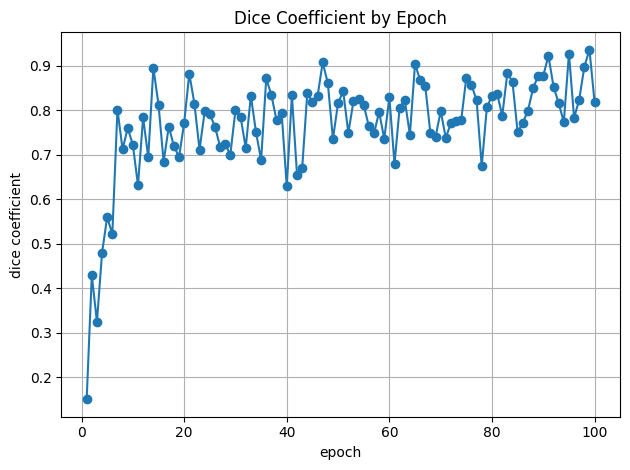

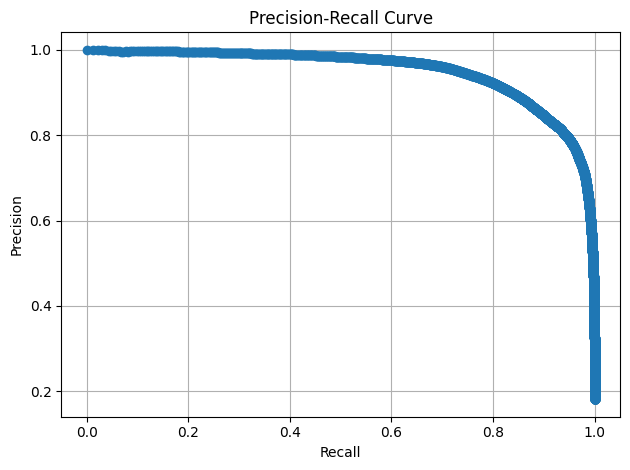

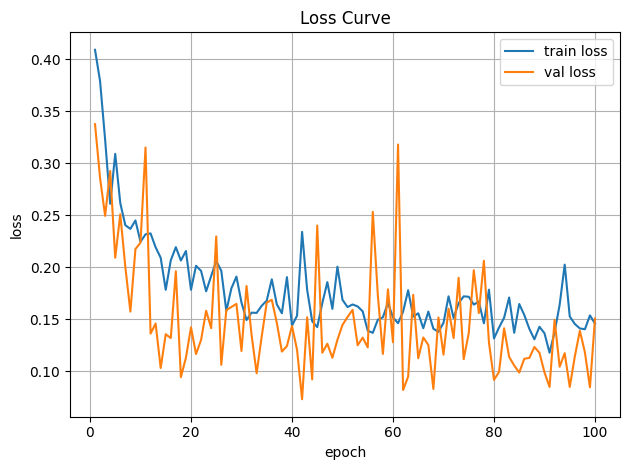

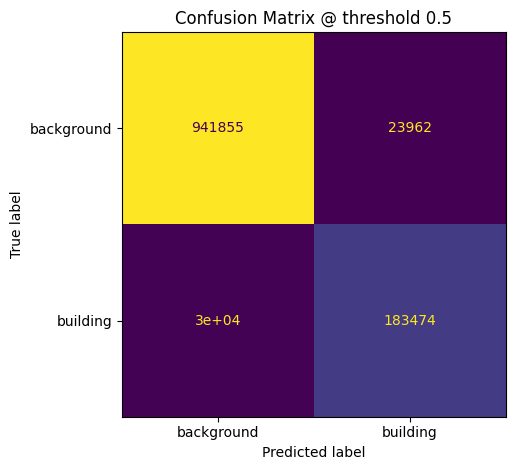

In [6]:
import csv, numpy as np

# === 讀入你先前程式已算好的資料 ===
metrics_csv = "metrics.csv"
val_pred_npz = "val_pred.npz"

# ── 1. Dice-by-epoch  ───────────────────────────────────────────────
epochs, dice = [], []
with open(metrics_csv, newline="") as f:
    for row in csv.DictReader(f):
        epochs.append(int(row["epoch"]))
        dice.append(float(row["dice"]))

with open("dice_by_epoch.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["epoch", "dice"])
    w.writerows(zip(epochs, dice))
print("✅ dice_by_epoch.csv  已寫出")
plt.figure()
plt.plot(epochs, dice, marker='o')
plt.xlabel("epoch"); plt.ylabel("dice coefficient")
plt.title("Dice Coefficient by Epoch")
plt.grid(); plt.tight_layout()
plt.savefig("dice_curve.png")

# ── 2. Precision-Recall 曲線  ───────────────────────────────────────
dat = np.load(val_pred_npz)
y_true, y_score = dat["y_true"], dat["y_score"]

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# precision, recall 長度 = len(thresholds)+1，為了對齊，先手動補最後一個門檻值 1.0
thresholds = np.append(thresholds, 1.0)

with open("pr_curve.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["threshold", "recall", "precision"])
    w.writerows(zip(thresholds, recall, precision))
print("✅ pr_curve.csv       已寫出")
plt.figure()
plt.plot(recall, precision, marker='o')
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(); plt.tight_layout()
plt.savefig("pr_curve.png")
# === 3. Loss Curve ────────────────────────────────────────────────
import matplotlib.pyplot as plt

# 如果 metrics.csv 還有 train_loss / val_loss 欄，讀進來：
train_loss, val_loss = [], []
with open(metrics_csv, newline="") as f:
    for row in csv.DictReader(f):
        train_loss.append(float(row["train_loss"]))
        val_loss.append(float(row["val_loss"]))

plt.figure()
plt.plot(epochs, train_loss, label="train loss")
plt.plot(epochs, val_loss,  label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss Curve")
plt.grid(); plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png")
print("✅ loss_curve.png     已寫出")

# === 4. Confusion Matrix ──────────────────────────────────────────
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 以固定門檻 0.5 取 y_pred；如要用最佳 F1 門檻可自行替換
y_pred = (y_score >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])   # [[TN, FP], [FN, TP]]

fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(cm, display_labels=["background", "building"])  # 按你的類別改
disp.plot(cmap=None, ax=ax, colorbar=False)  # 不指定 color 以符合預設
ax.set_title("Confusion Matrix @ threshold 0.5")
plt.tight_layout()
fig.savefig("conf_matrix.png")
print("✅ conf_matrix.png    已寫出")


In [9]:
# ------------------ Demo Predict (RGB + Depth，滑窗版 1024×1024) ------------------
"""
此腳本示範如何對 **RGB 圖 + 單通道深度圖** 進行語意分割推論。
假設模型輸入為 4 通道（RGB→3 + Depth→1）。
"""
import os
from typing import Tuple, List

import numpy as np
from PIL import Image

import torch
import torch.nn.functional as F
import torchvision

# ------------------------------------------------------------
# ⚙️ 1. 手動設定
# ------------------------------------------------------------
RGB_PATH   = r"E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1.tif"      # 三通道 RGB 影像
DEPTH_PATH = r"E:\論文\空拍地圖語意分割\Depth4UNet\depth\bellingham1_depth.png"    # 對應深度圖 (單通道 or 16‑bit)
CKPT_PATH  = r"E:\論文\空拍地圖語意分割\Depth4UNet\checkpoints\best_unet4ch.pth"

WINDOW_SIZE = 1024  # 滑窗大小
STRIDE      = 512   # 滑窗步長（50% 重疊，減少邊界效應）

# ------------------------------------------------------------
# ⚙️ 2. 運算裝置
# ------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", DEVICE)

# ------------------------------------------------------------
# ⚙️ 3. 載入模型（UNet11_4ch，RGBD → 1 類）
# ------------------------------------------------------------
#from model import UNet11_4ch  # 若想換 UNet16_4ch，這裡替換即可

model = UNet11_4ch(pretrained=False).to(DEVICE).eval()
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))

# ------------------------------------------------------------
# ⚙️ 4. 影像讀取
# ------------------------------------------------------------
print("📥 Loading images …")
# 讀取 RGB（H×W×3，uint8）
rgb_img = Image.open(RGB_PATH).convert("RGB")
# 讀取 Depth（H×W 單通道）；自動轉成 8‑bit 再正規化 0–1
raw_depth = Image.open(DEPTH_PATH)
if raw_depth.mode != "L":  # 16‑bit or 32‑bit
    depth_np = np.array(raw_depth, dtype=np.float32)
    # 依整張圖做 min‑max → 0‑255 再轉 uint8（便於與 RGB 同步前處理）
    depth_np = 255.0 * (depth_np - depth_np.min()) / max(depth_np.ptp(), 1e-6)
    depth_img = Image.fromarray(depth_np.astype(np.uint8))
else:
    depth_img = raw_depth

W, H = rgb_img.size
print(f"📐 Image size: {W}×{H}")

# ------------------------------------------------------------
# ⚙️ 5. 前處理函式
# ------------------------------------------------------------
# 針對 RGB 的 torchvision 標準化 (ImageNet)
_rgb_tf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
])

# Depth → Tensor (0–1) 直接線性拉伸；不做均值方差正規化（依照你訓練時的做法調整）
_depth_tf = torchvision.transforms.ToTensor()  # 會得到 0–1 float32


def preprocess_patch(rgb_patch: Image.Image, depth_patch: Image.Image) -> torch.Tensor:
    """將 RGB 與 Depth patch 轉為 (1,4,H,W) Tensor 並 pad 到 32 倍數"""
    t_rgb   = _rgb_tf(rgb_patch)
    t_depth = _depth_tf(depth_patch)  # shape (1,H,W)
    tensor  = torch.cat([t_rgb, t_depth], dim=0).unsqueeze(0).to(DEVICE)  # (1,4,H,W)
    return tensor


# ------------------------------------------------------------
# ⚙️ 6. Pad‑to‑32 工具
# ------------------------------------------------------------

def pad32(x: torch.Tensor) -> Tuple[torch.Tensor, int, int]:
    """Pad tensor (N,C,H,W) 到 32 的倍數，回傳 pad 後 tensor 與 pady、padx"""
    _, _, h, w = x.shape
    ph = (32 - h % 32) % 32
    pw = (32 - w % 32) % 32
    return F.pad(x, (0, pw, 0, ph)), ph, pw


# ------------------------------------------------------------
# ⚙️ 7. 小圖直接預測
# ------------------------------------------------------------

def direct_predict(rgb_np: np.ndarray, depth_np: np.ndarray) -> np.ndarray:
    print("📸 Image is small, using direct prediction…")
    rgb_pil   = Image.fromarray(rgb_np)
    depth_pil = Image.fromarray(depth_np)

    tensor_img = preprocess_patch(rgb_pil, depth_pil)
    tensor_pad, ph, pw = pad32(tensor_img)

    with torch.no_grad():
        logits = model(tensor_pad)
        if ph or pw:
            logits = logits[..., : logits.shape[-2] - ph, : logits.shape[-1] - pw]
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
    return prob


# ------------------------------------------------------------
# ⚙️ 8. 滑窗預測
# ------------------------------------------------------------

def sliding_window_predict(rgb_np: np.ndarray, depth_np: np.ndarray,
                           window: int, stride: int) -> np.ndarray:
    H, W, _ = rgb_np.shape

    # 若圖片小於滑窗，直接預測
    if H <= window and W <= window:
        return direct_predict(rgb_np, depth_np)

    print("🖼️ Image is large, using sliding window prediction…")

    out_mask = np.zeros((H, W), dtype=np.float32)
    weight   = np.zeros((H, W), dtype=np.float32)

    y_pos = list(range(0, max(1, H - window + 1), stride))
    x_pos = list(range(0, max(1, W - window + 1), stride))

    if y_pos[-1] + window < H:
        y_pos.append(H - window)
    if x_pos[-1] + window < W:
        x_pos.append(W - window)

    total = len(y_pos) * len(x_pos)
    print(f"🔄 Processing {total} windows…")

    idx = 0
    for y in y_pos:
        for x in x_pos:
            idx += 1
            y_end, x_end = y + window, x + window
            rgb_win   = rgb_np[y: y_end, x: x_end]
            depth_win = depth_np[y: y_end, x: x_end]

            # 若邊界不足則 pad 至 window
            if rgb_win.shape[0] < window or rgb_win.shape[1] < window:
                pad_rgb   = np.zeros((window, window, 3), dtype=np.uint8)
                pad_depth = np.zeros((window, window), dtype=np.uint8)
                pad_rgb[: rgb_win.shape[0], : rgb_win.shape[1], :]   = rgb_win
                pad_depth[: depth_win.shape[0], : depth_win.shape[1]] = depth_win
                rgb_win, depth_win = pad_rgb, pad_depth

            tensor_pad, ph, pw = pad32(preprocess_patch(Image.fromarray(rgb_win),
                                                        Image.fromarray(depth_win)))
            with torch.no_grad():
                logits = model(tensor_pad)
                if ph or pw:
                    logits = logits[..., : logits.shape[-2] - ph, : logits.shape[-1] - pw]
                prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

                # 若邊界 pad → 裁回原大小
                prob = prob[: rgb_win.shape[0], : rgb_win.shape[1]]

            out_mask[y: y_end, x: x_end] += prob[: y_end - y, : x_end - x]
            weight[y: y_end, x: x_end]   += 1.0

            if idx % 10 == 0 or idx == total:
                print(f"  Progress: {idx}/{total} ({idx / total * 100:.1f}%)")

    return np.divide(out_mask, weight, out=np.zeros_like(out_mask), where=weight != 0)


# ------------------------------------------------------------
# ⚙️ 9. 執行預測
# ------------------------------------------------------------
print("🔍 Starting prediction…")

rgb_np   = np.array(rgb_img)
depth_np = np.array(depth_img)

prob_mask = sliding_window_predict(rgb_np, depth_np, WINDOW_SIZE, STRIDE)

# ------------------------------------------------------------
# ⚙️ 10. 後處理與儲存
# ------------------------------------------------------------
THRESH = 0.5
binary = (prob_mask > THRESH).astype(np.uint8) * 255

mask_rgb = np.zeros((*binary.shape, 3), dtype=np.uint8)
mask_rgb[..., 1] = binary  # 綠色

blend = Image.blend(rgb_img, Image.fromarray(mask_rgb), alpha=0.4)

out_base = os.path.splitext(RGB_PATH)[0]
blend.save(out_base + "_RGBD_pred.png")
Image.fromarray(binary).save(out_base + "_RGBD_mask.png")

print("✅ Saved blended result:", out_base + "_RGBD_pred.png")
print("✅ Saved mask:", out_base + "_RGBD_mask.png")
print("🎉 Prediction completed!")


🚀 Using device: cuda


C:\Users\op237\AppData\Local\Temp\ipykernel_21292\2857281574.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CKPT_PATH, map_location=DE

📥 Loading images …
📐 Image size: 5000×5000
🔍 Starting prediction…
🖼️ Image is large, using sliding window prediction…
🔄 Processing 81 windows…
  Progress: 10/81 (12.3%)
  Progress: 20/81 (24.7%)
  Progress: 30/81 (37.0%)
  Progress: 40/81 (49.4%)
  Progress: 50/81 (61.7%)
  Progress: 60/81 (74.1%)
  Progress: 70/81 (86.4%)
  Progress: 80/81 (98.8%)
  Progress: 81/81 (100.0%)
✅ Saved blended result: E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1_RGBD_pred.png
✅ Saved mask: E:\論文\空拍地圖語意分割\Depth4UNet\AerialImageDataset\test\images\bellingham1_RGBD_mask.png
🎉 Prediction completed!
